In this notebook, I fitted a simple, one-layer KAN to Delaney's aqueous solubility dataset as a proof of concept. No test split or feature selection, just purely training.

In [27]:
# for imports
import sys, os
sys.path.append('../..')

# normal python data science stuff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from tqdm import tqdm

# my utility functions
from utils.data_utils import get_all_descriptors_from_smiles_list

In [28]:
# load dataset
filepath = '../../datasets/aqueous_solubility_delaney.csv'
df_delaney = pd.read_csv(filepath)
df_delaney.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [29]:
# get list of smiles strings
smiles_list = list(df_delaney.SMILES)

# compute all molecular descriptors and store in pandas dataframe
descriptors_df = get_all_descriptors_from_smiles_list(smiles_list, as_pandas=True)

100%|██████████| 1144/1144 [00:05<00:00, 224.07it/s]


In [30]:
descriptors_df.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,5.116512,5.116512,0.039352,-1.276235,0.487138,12.00,167.850,165.834,165.891061,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.060957,5.060957,1.083333,-1.083333,0.445171,12.00,133.405,130.381,131.930033,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.114198,5.114198,0.672840,-0.672840,0.527312,11.00,167.850,165.834,165.891061,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.095679,5.095679,0.308642,-0.405864,0.480258,9.60,133.405,130.381,131.930033,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11.544753,11.544753,3.685957,-4.226080,0.553756,14.25,187.375,187.375,185.901768,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Pearson Correlation Coefficients for All Molecular Descriptors Calculated\n for SMILES Strings in Delaney Aqueous Solubility Dataset')

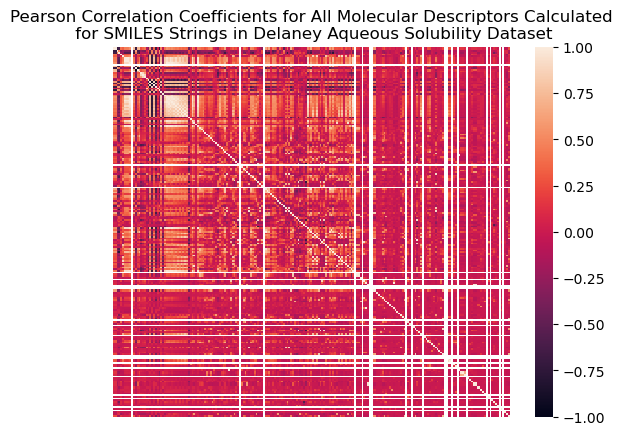

In [31]:
sns.heatmap(descriptors_df.corr(), vmin=-1, vmax=1, xticklabels=False, yticklabels=False)
plt.title('Pearson Correlation Coefficients for All Molecular Descriptors Calculated\n for SMILES Strings in Delaney Aqueous Solubility Dataset')

In [32]:
# features
X = descriptors_df.values

# target
y = df_delaney['measured log(solubility:mol/L)'].values

print(f'''number of samples: {X.shape[0]}
number of features: {X.shape[1]}''')

number of samples: 1144
number of features: 217


In [33]:
# check that number of samples in X and y match
assert X.shape[0] == y.shape[0], 'mismatch between number of samples and number of target values'

X.shape, y.shape

((1144, 217), (1144,))

# Experimenting with KANs - Simple training loop

In [34]:
# KAN imports
from kan import KANLayer

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# sklearn imports
from sklearn.preprocessing import StandardScaler

# for debugging/stepping through code
import pdb

In [35]:
# definig a single layer KAN
class BasicKAN(nn.Module):
    def __init__(self):
        super(BasicKAN, self).__init__()

        self.kan_layer_1 = KANLayer(in_dim=X.shape[1], out_dim=1)

    def forward(self, x):
        return self.kan_layer_1(x)

In [36]:
torch.manual_seed(1738)
model = BasicKAN()

In [37]:
X_torch = torch.from_numpy(X).to(torch.float32)
y_torch = torch.from_numpy(y).to(torch.float32)

In [38]:
# standarize features because some have extremely high values that are messing up the model
scaler = StandardScaler()

X_torch_scaled = torch.from_numpy(scaler.fit_transform(X_torch)).to(torch.float32)

# make sure shape, type, and data type match the original
assert X_torch_scaled.shape == X_torch.shape, 'shape mismatch'
assert X_torch_scaled.dtype == X_torch.dtype, 'data type mismatch'
assert X_torch_scaled.type() == X_torch.type(), 'type mismatch'

In [39]:
# simple training loop
torch.manual_seed(1738)
num_itrs = 500
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses = torch.zeros(size=(num_itrs,))
r2s = torch.zeros(size=(num_itrs,))

for i in range(num_itrs):
    optimizer.zero_grad()

    y_hat, preacts, postacts, postspline = model(X_torch_scaled)
    y_hat = y_hat.squeeze()

    loss = F.mse_loss(y_hat, y_torch)
    r2 = torch.detach(1 - (torch.sum((y_torch - y_hat)**2) / torch.sum((y_torch - torch.mean(y_torch))**2)))

    loss.backward()
    optimizer.step()

    losses[i] = loss.detach()
    r2s[i] = r2

    if i % 50 == 0:
        print(f'iteration {i}, loss: {loss.item()}, r2: {r2.item()}')
        

iteration 0, loss: 13.97418212890625, r2: -2.1821136474609375
iteration 50, loss: 0.48686179518699646, r2: 0.8891348838806152
iteration 100, loss: 0.31426361203193665, r2: 0.9284378290176392
iteration 150, loss: 0.24636709690093994, r2: 0.9438987970352173
iteration 200, loss: 0.2060098946094513, r2: 0.9530887007713318
iteration 250, loss: 0.17716369032859802, r2: 0.9596573710441589
iteration 300, loss: 0.15492624044418335, r2: 0.964721143245697
iteration 350, loss: 0.13788463175296783, r2: 0.9686017632484436
iteration 400, loss: 0.12470178306102753, r2: 0.9716036915779114
iteration 450, loss: 0.11410856992006302, r2: 0.9740158915519714


Text(0, 0.5, 'R^2')

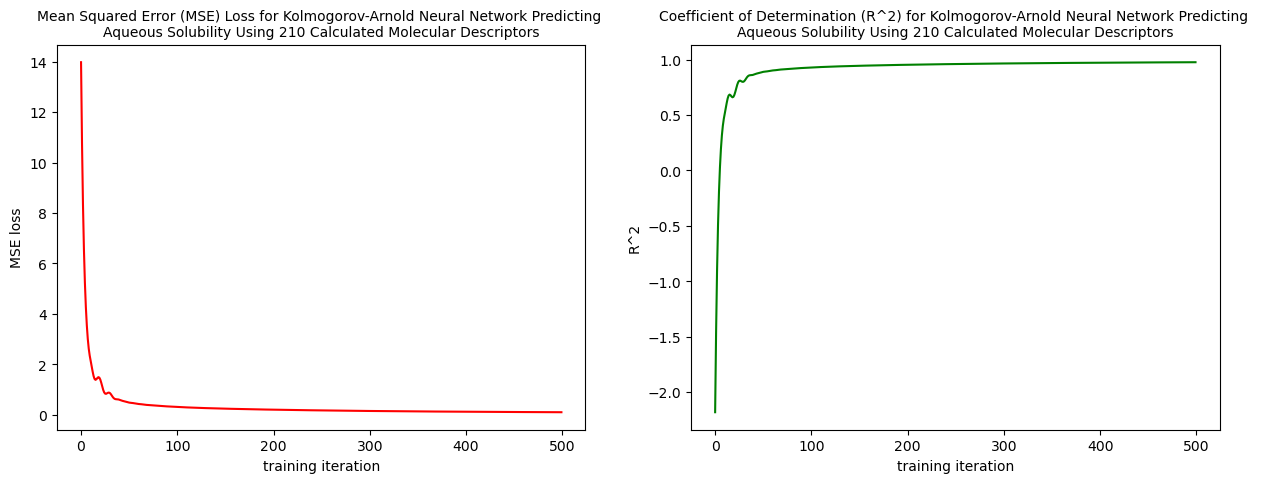

In [40]:
# plot losses and r2 in a side-by-side plot
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

plt.title('Losses and R^2 for Kolmogorov-Arnold Neural Network Predicting Aqueous Solubility Using 210 Calculated Molecular Descriptors')

ax[0].plot(losses, c='r')
ax[0].set_title('Mean Squared Error (MSE) Loss for Kolmogorov-Arnold Neural Network Predicting \nAqueous Solubility Using 210 Calculated Molecular Descriptors'\
                ,fontdict={'fontsize': 10})
ax[0].set_xlabel('training iteration')
ax[0].set_ylabel('MSE loss')

ax[1].plot(r2s, c='g')
ax[1].set_title('Coefficient of Determination (R^2) for Kolmogorov-Arnold Neural Network Predicting \nAqueous Solubility Using 210 Calculated Molecular Descriptors'\
                ,fontdict={'fontsize': 10})
ax[1].set_xlabel('training iteration')
ax[1].set_ylabel('R^2')
